## Create stacking models: first investigation

In [7]:
import time
import os
import math
import csv
from pathlib import Path
import numpy as np
import pinard as pn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

from pinard import utils
from pinard import preprocessing as pp
from pinard.model_selection import train_test_split_idx

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from xgboost import XGBRegressor


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

### Importation of the datasets

In [10]:
# Function to load a CSV file with automatic separator detection

def load_csv_auto_sep(path):
    with open(path, 'r', newline='', encoding='utf-8') as f:
        # Read a small portion of the file to detect the separator
        excerpt = f.read(1024)
        f.seek(0)  # return to the beginning of the file

        # Detection of the dialect
        dialect = csv.Sniffer().sniff(excerpt)
        sep = dialect.delimiter

        print("Detected separator : %s" % sep)
        
        # Load the file with pandas
        df = pd.read_csv(f, delimiter=sep)
        return df

In [11]:
mode = 'Regression' # 'Classification' or 'Regression'
 
## Choose the source of data to be imported
# Regression: 'BeerOriginalExtract' or 'Digest_0.8' or 'YamProtein' //
# Classification: 'CoffeeSpecies' or 'Malaria2024' or 'mDigest_custom3' or 'WhiskyConcentration' or 'YamMould'
data_source = 'YamProtein'


## Importation of the datasets with the adapted path
file_name = Path("Data/%s/%s"% (mode,data_source))
full_path = str(file_name.resolve()).replace("\\", "/")

Xcal = load_csv_auto_sep(f'{full_path}/Xcal.csv')
Xval = load_csv_auto_sep(f'{full_path}/Xval.csv')
Ycal = load_csv_auto_sep(f'{full_path}/Ycal.csv')
Yval = load_csv_auto_sep(f'{full_path}/Yval.csv')

print("Number of spectra for calibration: ", len(Ycal))
print("Number of spectra for test: ", len(Yval))
display(Xcal.head(5))

Detected separator : ;
Detected separator : ;
Detected separator : 
Detected separator : 
Number of spectra for calibration:  784
Number of spectra for test:  248


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V1011,V1012,V1013,V1014,V1015,V1016,V1017,V1018,V1019,V1020,V1021,V1022,V1023,V1024,V1025,V1026,V1027,V1028,V1029,V1030,V1031,V1032,V1033,V1034,V1035,V1036,V1037,V1038,V1039,V1040,V1041,V1042,V1043,V1044,V1045,V1046,V1047,V1048,V1049,V1050
0,0.163048,0.168517,0.173601,0.178055,0.181673,0.184674,0.187279,0.189404,0.190971,0.192225,0.193210,0.193820,0.194084,0.194121,0.193945,0.193377,0.192639,0.192019,0.191346,0.190369,0.189235,0.188254,0.187385,0.186347,0.185065,0.183726,0.182629,0.181779,0.180926,0.179943,0.178944,0.178091,0.177413,0.176828,0.176184,0.175272,0.174186,0.173189,0.172366,0.171607,...,0.590198,0.595115,0.600157,0.605289,0.610469,0.615764,0.621131,0.626551,0.632002,0.637506,0.642977,0.648276,0.653551,0.658811,0.663865,0.668885,0.673807,0.678505,0.683115,0.687693,0.692157,0.696513,0.700853,0.705097,0.709200,0.713056,0.716748,0.720253,0.723428,0.726172,0.728563,0.730664,0.732373,0.733608,0.734403,0.734922,0.735155,0.735095,0.734736,0.734165
1,0.159370,0.164547,0.169495,0.173999,0.177437,0.180028,0.182533,0.184882,0.186467,0.187515,0.188330,0.188839,0.189031,0.189084,0.189000,0.188627,0.188065,0.187462,0.186814,0.186016,0.184924,0.183744,0.182684,0.181593,0.180361,0.179250,0.178376,0.177459,0.176368,0.175334,0.174490,0.173748,0.173089,0.172442,0.171676,0.170765,0.169885,0.169100,0.168256,0.167227,...,0.584644,0.589536,0.594423,0.599369,0.604410,0.609614,0.614910,0.620256,0.625678,0.631119,0.636522,0.641761,0.646903,0.652027,0.657011,0.661867,0.666613,0.671262,0.675868,0.680378,0.684710,0.688998,0.693227,0.697311,0.701184,0.704965,0.708531,0.711861,0.714997,0.717707,0.720091,0.722194,0.723811,0.725038,0.725865,0.726412,0.726530,0.726389,0.726011,0.725416
2,0.163048,0.168517,0.173601,0.178055,0.181673,0.184674,0.187279,0.189404,0.190971,0.192225,0.193210,0.193820,0.194084,0.194121,0.193945,0.193377,0.192639,0.192019,0.191346,0.190369,0.189235,0.188254,0.187385,0.186347,0.185065,0.183726,0.182629,0.181779,0.180926,0.179943,0.178944,0.178091,0.177413,0.176828,0.176184,0.175272,0.174186,0.173189,0.172366,0.171607,...,0.590198,0.595115,0.600157,0.605289,0.610469,0.615764,0.621131,0.626551,0.632002,0.637506,0.642977,0.648276,0.653551,0.658811,0.663865,0.668885,0.673807,0.678505,0.683115,0.687693,0.692157,0.696513,0.700853,0.705097,0.709200,0.713056,0.716748,0.720253,0.723428,0.726172,0.728563,0.730664,0.732373,0.733608,0.734403,0.734922,0.735155,0.735095,0.734736,0.734165
3,0.159370,0.164547,0.169495,0.173999,0.177437,0.180028,0.182533,0.184882,0.186467,0.187515,0.188330,0.188839,0.189031,0.189084,0.189000,0.188627,0.188065,0.187462,0.186814,0.186016,0.184924,0.183744,0.182684,0.181593,0.180361,0.179250,0.178376,0.177459,0.176368,0.175334,0.174490,0.173748,0.173089,0.172442,0.171676,0.170765,0.169885,0.169100,0.168256,0.167227,...,0.584644,0.589536,0.594423,0.599369,0.604410,0.609614,0.614910,0.620256,0.625678,0.631119,0.636522,0.641761,0.646903,0.652027,0.657011,0.661867,0.666613,0.671262,0.675868,0.680378,0.684710,0.688998,0.693227,0.697311,0.701184,0.704965,0.708531,0.711861,0.714997,0.717707,0.720091,0.722194,0.723811,0.725038,0.725865,0.726412,0.726530,0.726389,0.726011,0.725416
4,0.148814,0.153634,0.157951,0.161528,0.164204,0.166344,0.168472,0.170332,0.171494,0.172274,0.172794,0.172970,0.172961,0.172734,0.172014,0.170886,0.169922,0.169199,0.168369,0.167340,0.166180,0.164944,0.163653,0.162280,0.160801,0.159385,0.158254,0.157257,0.156106,0.154969,0.154116,0.153385,0.152663,0.151992,0.151297,0.150462,0.149606,0.148802,0.148007,0.147178,...,0.580918,0.585865,0.590870,0.595954,0.601122,0.606336,0.611682,0.617103,0.622529,0.627988,0.633438,0.638781,0.643968,0.649073,0.654127,0.659070,0.663832,0.668490,0.673048,0.677545,0.681924,0.686239,0.690483,0.694642,0.698622,0.702400,0.706111,0.709491,0.712546,0.715371,0.717764,0.719747,0.721370,0.722661,0.723523,0.724061,0.724311,0

### Construction of the pipelines

In [ ]:
rd_seed = 42
rd_seed = np.random.seed(rd_seed)

x, y = pd.concat([Xcal,Xval], axis=0).values, pd.concat([Ycal,Yval], axis=0).values

### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]

# create a pipeline that applies min-max scaling followed by preprocessing
union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessing))

# this function creates a pipeline that applies the union_pipeline followed by the regressor
def get_estimator(regressor):
    pipeline = make_pipeline(union_pipeline, regressor)
    return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

# create a list of estimators to use in the stacking regressor, each one is a pipeline of the union_pipeline and a regressor
estimators = [
    ("Linear Regression", get_estimator( LinearRegression() ) ),
    ("PLS", get_estimator( PLSRegression(n_components=10) ) ),
    ("PLS_small", get_estimator( PLSRegression(n_components=3) ) ),
    ("XGBoost", get_estimator( XGBRegressor() ) )
]

# create the stacking regressor, using the list of estimators and a final regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=rd_seed))

### Calibration and visualization

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1

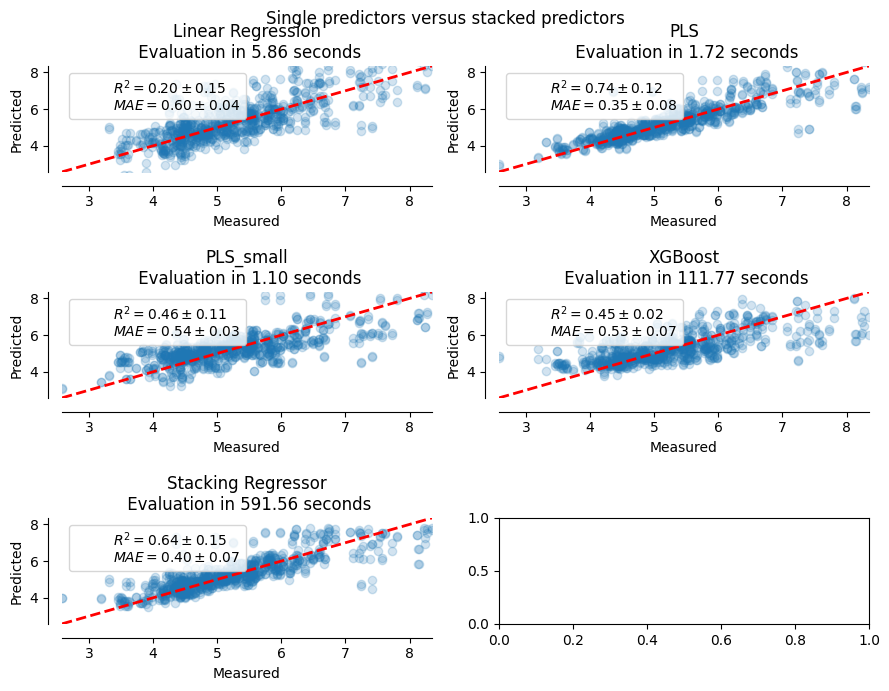

In [45]:
# function to plot a scatter plot of the predicted vs true targets,
# along with the scores and elapsed time of the model
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    # plot the line y=x for reference
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    # formatting the plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(3, 2, figsize=(9, 7))
axs = np.ravel(axs)

# looping through estimators and the stacking regressor
for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    start_time = time.time()
    # using cross_validate to get scores and elapsed time
    score = cross_validate(est, x, y, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2)
    elapsed_time = time.time() - start_time

    # using cross_val_predict to get predicted values
    y_pred = cross_val_predict(est, x, y, cv=4, n_jobs=2, verbose=1)

    # call the plot_regression_results function
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

# add subtitle and show the scatter plot
plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Influence of the splitting method

In [16]:
rd_seed = 42
rd_seed = np.random.seed(rd_seed)

x = pd.concat([Xcal, Xval], axis=0)
y = pd.concat([Ycal, Yval], axis=0)

# split the data into training and test sets with the Kennard Stone method
train_index, test_index = train_test_split_idx(x.values, 
                                               y.values,
                                               test_size=0.3, 
                                               method="kennard_stone", 
                                               random_state=rd_seed, 
                                               metric="euclidean"
                                               )

X_train, y_train, X_test, y_test = x.iloc[train_index], y.iloc[train_index], x.iloc[test_index], y.iloc[test_index]

In [ ]:
### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]

# create a pipeline that applies min-max scaling followed by preprocessing
union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessing))

# this function creates a pipeline that applies the union_pipeline followed by the regressor
def get_estimator(regressor):
    pipeline = make_pipeline(union_pipeline, regressor)
    return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

# create a list of estimators to use in the stacking regressor, each one is a pipeline of the union_pipeline and a regressor
estimators = [
    ("Linear Regression", get_estimator( LinearRegression() ) ),
    ("PLS", get_estimator( PLSRegression(n_components=10) ) ),
    ("PLS_small", get_estimator( PLSRegression(n_components=3) ) ),
    ("XGBoost", get_estimator( XGBRegressor() ) )
]

# create the stacking regressor, using the list of estimators and a final regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=rd_seed))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    5.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1

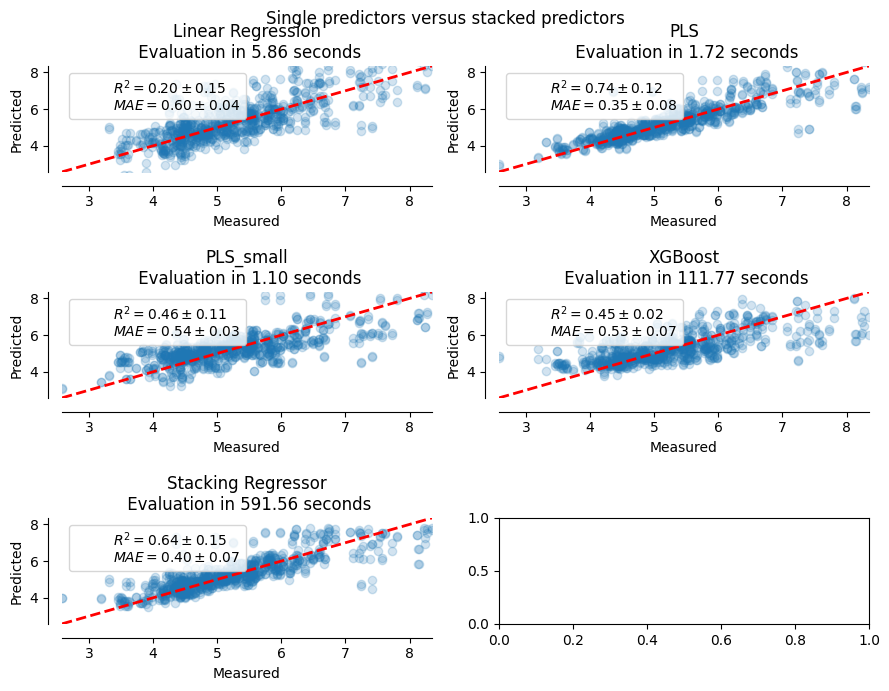

In [ ]:
# function to plot a scatter plot of the predicted vs true targets,
# along with the scores and elapsed time of the model
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    # plot the line y=x for reference
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    # formatting the plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(3, 2, figsize=(9, 7))
axs = np.ravel(axs)

# looping through estimators and the stacking regressor
for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    
    if name == "Stacking Regressor":
        start_time = time.time()
        # using cross_validate to get scores and elapsed time
        score = cross_validate(est, X_train, y_train, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2)
        elapsed_time = time.time() - start_time

    # using cross_val_predict to get predicted values
    y_pred = est.predict(est, X_test, y_test, cv=4, n_jobs=2, verbose=1)

    # call the plot_regression_results function
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

# add subtitle and show the scatter plot
plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()